In [1]:
#python basics
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

#this is just cool
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
from collections import defaultdict
import wordcloud

#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

#for neural nets
import tensorflow as tf

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(34)

### I. Data Extraction / Exploration / transformation

In [3]:
train = pd.read_csv("./train.csv")
test= pd.read_csv("./test.csv")

In [4]:
print(train.shape)
train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(test.shape)
test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

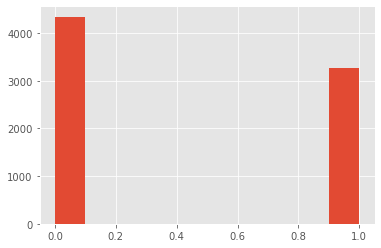

In [6]:
# Distribution of target label in train set
plt.hist(train['target'])
train['target'].describe()

In [7]:
#Find missing value counts
print(train.isnull().sum())
train.shape

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


(7613, 5)

In [8]:
test_id = test['id']

### clean up

In [9]:
#drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#fill missing with unknown
train['keyword'] = train['keyword'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')

#change text to unknown if NaN
train['text'] = train['text'].fillna('unknown')
test['text'] = test['text'].fillna('unknown')

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']


#drop fkeyword rom train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#combine so we work smarter, not harder
total = train.append(test)
# total = total[total['text'].notna()]

In [10]:
test

,text
0,Just happened a terrible car crash unknown
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires unknown
4,Typhoon Soudelor kills 28 in China and Taiwan ...
...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,Storm in RI worse than last hurricane. My city...
3260,Green Line derailment in Chicago http://t.co/U...
3261,MEG issues Hazardous Weather Outlook (HWO) htt...


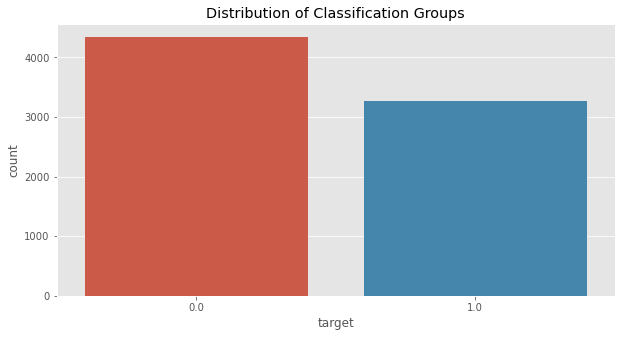

In [11]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = total)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

### Transform features to get meaningful data

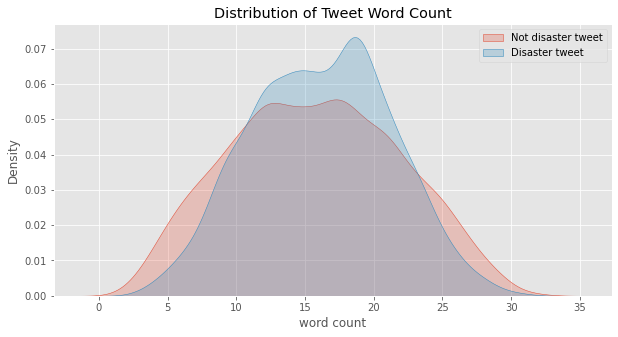

In [12]:
#create column for the number of words in tweet
total['word count'] = total['text'].apply(lambda x: len(x.split()))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['word count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['word count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Word Count')
plt.legend()
plt.show()

From above plot we understand majority of tweets have lenght ~10 to ~25

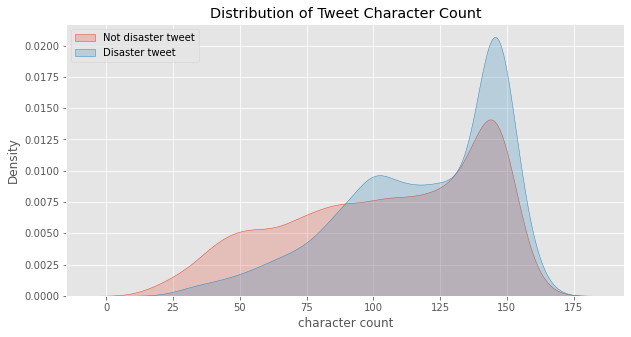

In [13]:
#create column for the number of characters in a tweet
total['character count'] = total['text'].apply(lambda x: len(x))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['character count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['character count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Character Count')
plt.rcParams['legend.loc'] = 'upper left'
plt.legend()
plt.show()

Few disaster tweets are less than 50 characters and that the majority of them are more than 125 characters long

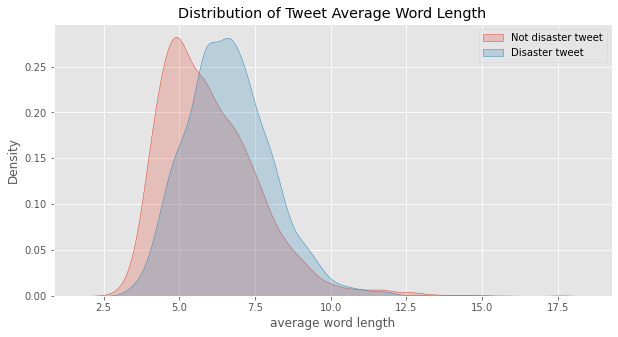

In [310]:
#define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#broadcast to text column
total['average word length'] = total['text'].apply(average_word_length)

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['average word length'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['average word length'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title
plt.title('Distribution of Tweet Average Word Length')
plt.rcParams['legend.loc'] = 'upper right'
plt.legend()
plt.show()

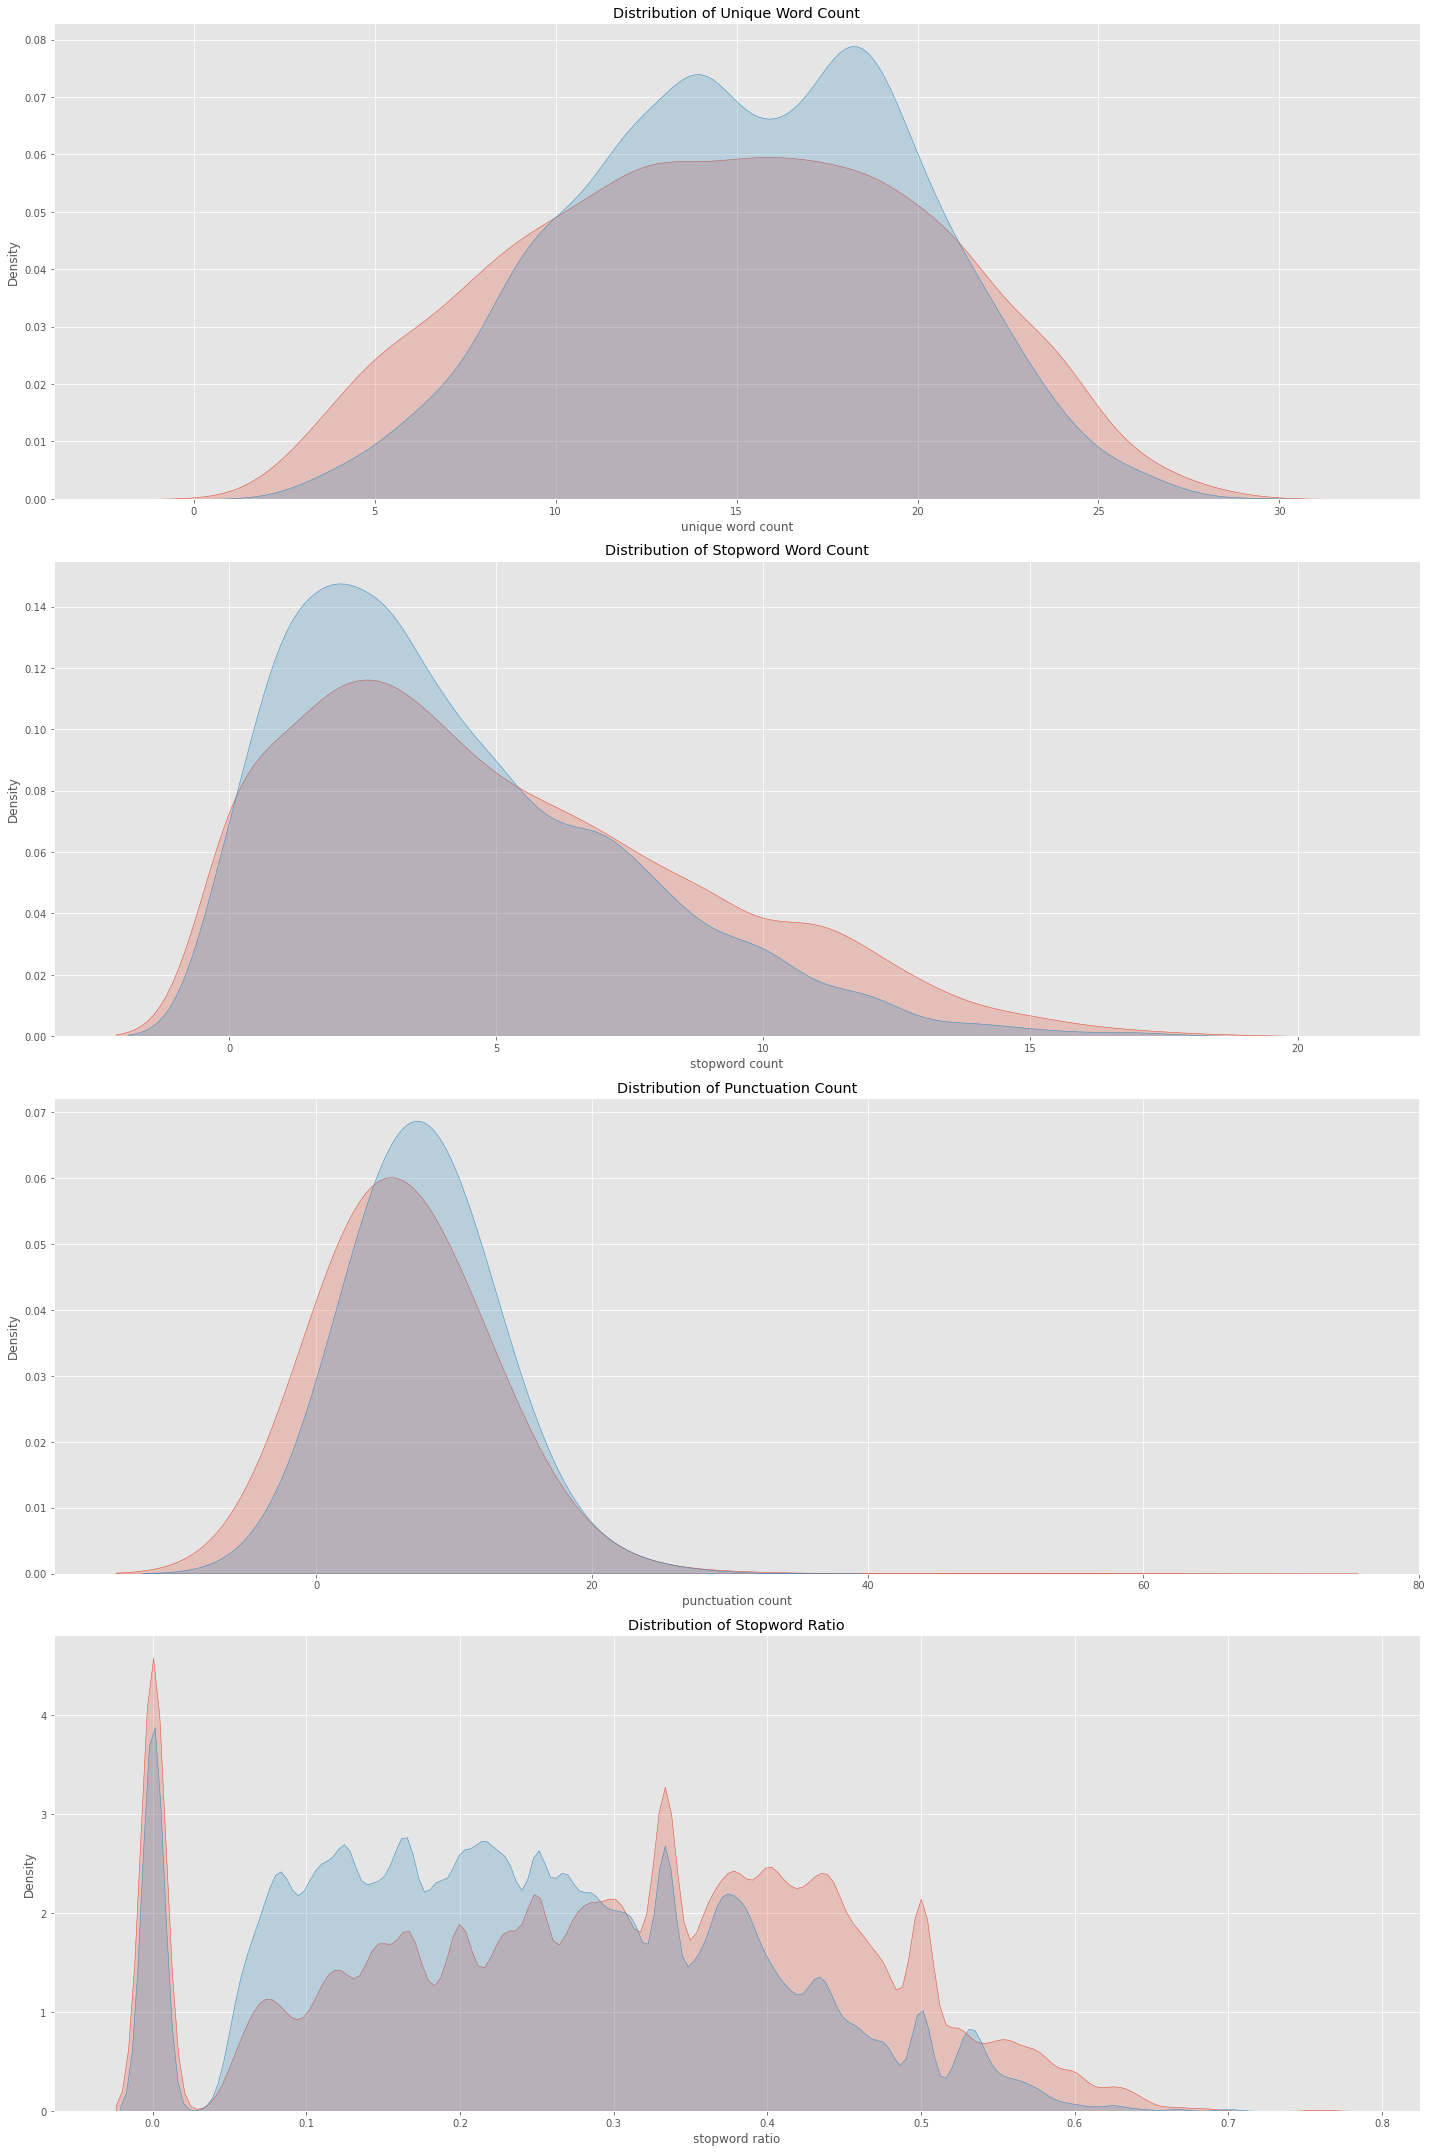

In [311]:
#add unique word count
total['unique word count'] = total['text'].apply(lambda x: len(set(x.split())))

#add stopword count
total['stopword count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

#add stopword ratio
total['stopword ratio'] = total['stopword count'] / total['word count']

#add punctuation count
total['punctuation count'] = total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#split so we can use updated train set
train = total[:len(train)]

disaster = train['target'] == 1

#produce graphs to visualize newly added features
fig, axes = plt.subplots(4, figsize=(20, 30))

graph1 = sns.kdeplot(train.loc[~disaster]['unique word count'], shade = True, label = 'Not Disaster', ax=axes[0])
graph1 = sns.kdeplot(train.loc[disaster]['unique word count'], shade = True, label = 'Disaster', ax=axes[0])
graph1.set_title('Distribution of Unique Word Count')

graph2 = sns.kdeplot(train.loc[~disaster]['stopword count'], shade = True, label = 'Not Disaster', ax=axes[1])
graph2 = sns.kdeplot(train.loc[disaster]['stopword count'], shade = True, label = 'Disaster', ax=axes[1])
graph2.set_title('Distribution of Stopword Word Count')

graph3 = sns.kdeplot(train.loc[~disaster]['punctuation count'], shade = True, label = 'Not Disaster', ax=axes[2], bw = 1)
graph3 = sns.kdeplot(train.loc[disaster]['punctuation count'], shade = True, label = 'Disaster', ax=axes[2], bw = 1)
graph3.set_title('Distribution of Punctuation Count')

graph4 = sns.kdeplot(train.loc[~disaster]['stopword ratio'], shade = True, label = 'Not Disaster', ax=axes[3], bw = .05)
graph4 = sns.kdeplot(train.loc[disaster]['stopword ratio'], shade = True, label = 'Disaster', ax=axes[3], bw = .05)
graph4.set_title('Distribution of Stopword Ratio')

fig.tight_layout()
plt.show()

### Text cleaning

In [312]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

from autocorrect import Speller 

#create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

# Expand word contractions https://stackoverflow.com/a/19794953 
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

def clean_tweets(x):
    #correct some acronyms while we are at it
    x = re.sub(r"tnwx", "Tennessee Weather", x)
    x = re.sub(r"azwx", "Arizona Weather", x)  
    x = re.sub(r"alwx", "Alabama Weather", x)
    x = re.sub(r"wordpressdotcom", "wordpress", x)      
    x = re.sub(r"gawx", "Georgia Weather", x)  
    x = re.sub(r"scwx", "South Carolina Weather", x)  
    x = re.sub(r"cawx", "California Weather", x)
    x = re.sub(r"usNWSgov", "United States National Weather Service", x) 
    x = re.sub(r"MH370", "Malaysia Airlines Flight 370", x)
    x = re.sub(r"okwx", "Oklahoma City Weather", x)
    x = re.sub(r"arwx", "Arkansas Weather", x)  
    x = re.sub(r"lmao", "laughing my ass off", x)  
    x = re.sub(r"amirite", "am I right", x)
    
    #and some typos/abbreviations
    x = re.sub(r"w/e", "whatever", x)
    x = re.sub(r"w/", "with", x)
    x = re.sub(r"USAgov", "USA government", x)
    x = re.sub(r"recentlu", "recently", x)
    x = re.sub(r"Ph0tos", "Photos", x)
    x = re.sub(r"exp0sed", "exposed", x)
    x = re.sub(r"<3", "love", x)
    x = re.sub(r"amageddon", "armageddon", x)
    x = re.sub(r"Trfc", "Traffic", x)
    x = re.sub(r"WindStorm", "Wind Storm", x)
    x = re.sub(r"16yr", "16 year", x)
    x = re.sub(r"TRAUMATISED", "traumatized", x)
    
    #hashtags and usernames
    x = re.sub(r"IranDeal", "Iran Deal", x)
    x = re.sub(r"ArianaGrande", "Ariana Grande", x)
    x = re.sub(r"camilacabello97", "camila cabello", x) 
    x = re.sub(r"RondaRousey", "Ronda Rousey", x)     
    x = re.sub(r"MTVHottest", "MTV Hottest", x)
    x = re.sub(r"TrapMusic", "Trap Music", x)
    x = re.sub(r"ProphetMuhammad", "Prophet Muhammad", x)
    x = re.sub(r"PantherAttack", "Panther Attack", x)
    x = re.sub(r"StrategicPatience", "Strategic Patience", x)
    x = re.sub(r"socialnews", "social news", x)
    x = re.sub(r"IDPs:", "Internally Displaced People :", x)
    x = re.sub(r"ArtistsUnited", "Artists United", x)
    x = re.sub(r"ClaytonBryant", "Clayton Bryant", x)
    x = re.sub(r"jimmyfallon", "jimmy fallon", x)
    x = re.sub(r"justinbieber", "justin bieber", x)  
    x = re.sub(r"Time2015", "Time 2015", x)
    x = re.sub(r"djicemoon", "dj icemoon", x)
    x = re.sub(r"LivingSafely", "Living Safely", x)
    x = re.sub(r"FIFA16", "Fifa 2016", x)
    x = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", x)
    x = re.sub(r"bbcnews", "bbc news", x)
    x = re.sub(r"UndergroundRailraod", "Underground Railraod", x)
    x = re.sub(r"c4news", "c4 news", x)
    x = re.sub(r"MUDSLIDE", "mudslide", x)
    x = re.sub(r"NoSurrender", "No Surrender", x)
    x = re.sub(r"NotExplained", "Not Explained", x)
    x = re.sub(r"greatbritishbakeoff", "great british bake off", x)
    x = re.sub(r"LondonFire", "London Fire", x)
    x = re.sub(r"KOTAWeather", "KOTA Weather", x)
    x = re.sub(r"LuchaUnderground", "Lucha Underground", x)
    x = re.sub(r"KOIN6News", "KOIN 6 News", x)
    x = re.sub(r"LiveOnK2", "Live On K2", x)
    x = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", x)
    x = re.sub(r"nikeplus", "nike plus", x)
    x = re.sub(r"david_cameron", "David Cameron", x)
    x = re.sub(r"peterjukes", "Peter Jukes", x)
    x = re.sub(r"MikeParrActor", "Michael Parr", x)
    x = re.sub(r"4PlayThursdays", "Foreplay Thursdays", x)
    x = re.sub(r"TGF2015", "Tontitown Grape Festival", x)
    x = re.sub(r"realmandyrain", "Mandy Rain", x)
    x = re.sub(r"GraysonDolan", "Grayson Dolan", x)
    x = re.sub(r"ApolloBrown", "Apollo Brown", x)
    x = re.sub(r"saddlebrooke", "Saddlebrooke", x)
    x = re.sub(r"TontitownGrape", "Tontitown Grape", x)
    x = re.sub(r"AbbsWinston", "Abbs Winston", x)
    x = re.sub(r"ShaunKing", "Shaun King", x)
    x = re.sub(r"MeekMill", "Meek Mill", x)
    x = re.sub(r"TornadoGiveaway", "Tornado Giveaway", x)
    x = re.sub(r"GRupdates", "GR updates", x)
    x = re.sub(r"SouthDowns", "South Downs", x)
    x = re.sub(r"braininjury", "brain injury", x)
    x = re.sub(r"auspol", "Australian politics", x)
    x = re.sub(r"PlannedParenthood", "Planned Parenthood", x)
    x = re.sub(r"calgaryweather", "Calgary Weather", x)
    x = re.sub(r"weallheartonedirection", "we all heart one direction", x)
    x = re.sub(r"edsheeran", "Ed Sheeran", x)
    x = re.sub(r"TrueHeroes", "True Heroes", x)
    x = re.sub(r"ComplexMag", "Complex Magazine", x)
    x = re.sub(r"TheAdvocateMag", "The Advocate Magazine", x)
    x = re.sub(r"CityofCalgary", "City of Calgary", x)
    x = re.sub(r"EbolaOutbreak", "Ebola Outbreak", x)
    x = re.sub(r"SummerFate", "Summer Fate", x)
    x = re.sub(r"RAmag", "Royal Academy Magazine", x)
    x = re.sub(r"offers2go", "offers to go", x)
    x = re.sub(r"ModiMinistry", "Modi Ministry", x)
    x = re.sub(r"TAXIWAYS", "taxi ways", x)
    x = re.sub(r"Calum5SOS", "Calum Hood", x)
    x = re.sub(r"JamesMelville", "James Melville", x)
    x = re.sub(r"JamaicaObserver", "Jamaica Observer", x)
    x = re.sub(r"xLikeItsSeptember11th2001", "x like it is september 11th 2001", x)
    x = re.sub(r"cbplawyers", "cbp lawyers", x)
    x = re.sub(r"fewmorexs", "few more xs", x)
    x = re.sub(r"BlackLivesMatter", "Black Lives Matter", x)
    x = re.sub(r"NASAHurricane", "NASA Hurricane", x)
    x = re.sub(r"onlinecommunities", "online communities", x)
    x = re.sub(r"humanconsumption", "human consumption", x)
    x = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", x)
    x = re.sub(r"Meat-Loving", "Meat Loving", x)
    x = re.sub(r"facialabuse", "facial abuse", x)
    x = re.sub(r"LakeCounty", "Lake County", x)
    x = re.sub(r"BeingAuthor", "Being Author", x)
    x = re.sub(r"withheavenly", "with heavenly", x)
    x = re.sub(r"thankU", "thank you", x)
    x = re.sub(r"iTunesMusic", "iTunes Music", x)
    x = re.sub(r"OffensiveContent", "Offensive Content", x)
    x = re.sub(r"WorstSummerJob", "Worst Summer Job", x)
    x = re.sub(r"HarryBeCareful", "Harry Be Careful", x)
    x = re.sub(r"NASASolarSystem", "NASA Solar System", x)
    x = re.sub(r"animalrescue", "animal rescue", x)
    x = re.sub(r"KurtSchlichter", "Kurt Schlichter", x)
    x = re.sub(r"Throwingknifes", "Throwing knives", x)
    x = re.sub(r"GodsLove", "God's Love", x)
    x = re.sub(r"bookboost", "book boost", x)
    x = re.sub(r"ibooklove", "I book love", x)
    x = re.sub(r"NestleIndia", "Nestle India", x)
    x = re.sub(r"realDonaldTrump", "Donald Trump", x)
    x = re.sub(r"DavidVonderhaar", "David Vonderhaar", x)
    x = re.sub(r"CecilTheLion", "Cecil The Lion", x)
    x = re.sub(r"weathernetwork", "weather network", x)
    x = re.sub(r"GOPDebate", "GOP Debate", x)
    x = re.sub(r"RickPerry", "Rick Perry", x)
    x = re.sub(r"frontpage", "front page", x)
    x = re.sub(r"NewsInxs", "News In xs", x)
    x = re.sub(r"ViralSpell", "Viral Spell", x)
    x = re.sub(r"til_now", "until now", x)
    x = re.sub(r"volcanoinRussia", "volcano in Russia", x)
    x = re.sub(r"ZippedNews", "Zipped News", x)
    x = re.sub(r"MicheleBachman", "Michele Bachman", x)
    x = re.sub(r"53inch", "53 inch", x)
    x = re.sub(r"KerrickTrial", "Kerrick Trial", x)
    x = re.sub(r"abstorm", "Alberta Storm", x)
    x = re.sub(r"Beyhive", "Beyonce hive", x)
    x = re.sub(r"RockyFire", "Rocky Fire", x)
    x = re.sub(r"Listen/Buy", "Listen / Buy", x)
    x = re.sub(r"ArtistsUnited", "Artists United", x)
    x = re.sub(r"ENGvAUS", "England vs Australia", x)
    x = re.sub(r"ScottWalker", "Scott Walker", x)
    return x

In [313]:
#total = total.sample(frac=0.25, replace=True)

In [314]:
CLEANUP = True    
if CLEANUP:
    total['text'] = total['text'].apply(lambda x: x.lower())
    total['text'] = total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
    total['text'] = total['text'].apply(remove_punctuation)
    total['text'] = total['text'].apply(remove_stopwords)
    total['text'] = total['text'].apply(remove_less_than)
    total['text'] = total['text'].apply(remove_non_alphabet)
    total['text'] = total['text'].apply(spell_check)
    total['text'] = total['text'].apply(expand_contractions)
    total['text'] = total['text'].apply(clean_tweets)
    total.to_pickle("./test_df.pkl")


In [14]:
total = pd.read_pickle("./test_df.pkl")

### II. Model

In [15]:
tweets = [tweet for tweet in total['text']]

#split data to update changes
train = total[:len(train)]
test = total[len(train):]

In [16]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import Input

to_exclude = '*+-/()%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)

#define tokenizer options
tokenizer = Tokenizer()     
#tokenizer = Tokenizer(oov_token = '<OOV>')           #if you wanted to tokenized OOV words
#tokenizer = Tokenizer(filters = to_exclude)          #if you wanted to include punctuation
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Using TensorFlow backend.


Found 16224 unique tokens.
Shape of data tensor: (10876, 21)
Shape of label tensor: (7613,)


In [17]:
# get GloVe vector embeddings
# Downloaded glove file from https://www.kaggle.com/incorpes/glove6b200d
embeddings_index = {}
with open('./glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:17, 23255.26it/s]

Found 400000 word vectors in the GloVe library


In [18]:
EMBEDDING_DIM = 200   #defined by size of GloVe word vector dimensions
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 16224/16224 [00:00<00:00, 332145.88it/s]

Our embedded matrix is of dimension (16225, 200)


In [19]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

#and scal
meta_train = scale(train, StandardScaler())
meta_test = scale(test, StandardScaler())

### LSTM

In [33]:
#function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal'))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [34]:
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          (None, 21)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 21, 200)      3245000     nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 21, 200)      0           embedding_1[1][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 200)          240800      spatial_dropout1d_3[0][0]        
____________________________________________________________________________________________

In [35]:
#fit model
history = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 30, batch_size = 21, verbose = 1)

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 33s 5ms/step - loss: 0.5617 - accuracy: 0.7356 - val_loss: 0.4506 - val_accuracy: 0.8135
Epoch 2/30
6090/6090 [==============================] - 42s 7ms/step - loss: 0.4964 - accuracy: 0.7829 - val_loss: 0.4429 - val_accuracy: 0.8142
Epoch 3/30
6090/6090 [==============================] - 36s 6ms/step - loss: 0.4765 - accuracy: 0.7885 - val_loss: 0.4350 - val_accuracy: 0.8162
Epoch 4/30
6090/6090 [==============================] - 29s 5ms/step - loss: 0.4715 - accuracy: 0.7957 - val_loss: 0.4340 - val_accuracy: 0.8162
Epoch 5/30
6090/6090 [==============================] - 30s 5ms/step - loss: 0.4561 - accuracy: 0.7990 - val_loss: 0.4329 - val_accuracy: 0.8135
Epoch 6/30
6090/6090 [==============================] - 36s 6ms/step - loss: 0.4440 - accuracy: 0.8044 - val_loss: 0.4317 - val_accuracy: 0.8076
Epoch 7/30
6090/6090 [==============================] - 32s 5ms/step - loss: 0.443

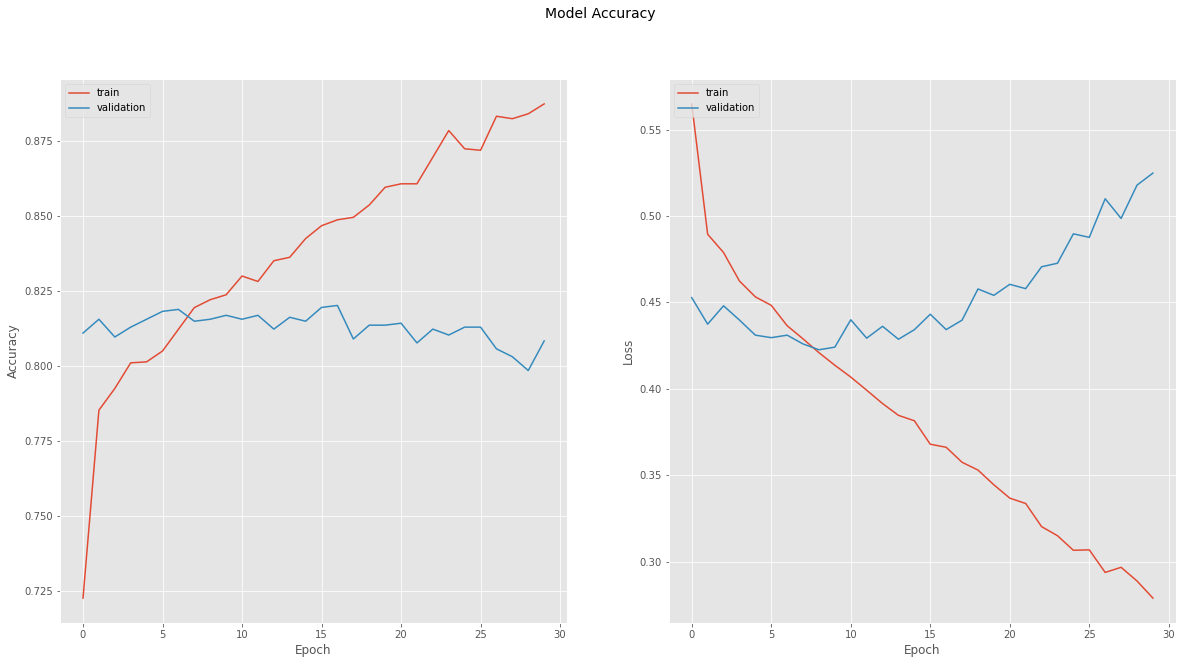

In [325]:
plot_learning_curves(history)

In [31]:
#create submission for complex lstm model
submission_lstm = pd.DataFrame()
submission_lstm['id'] = test_id
submission_lstm['prob'] = lstm.predict([nlp_test, meta_test])
submission_lstm['target'] = submission_lstm['prob'].apply(lambda x: 0 if x < .5 else 1)
submission_lstm.head(10)

NameError: name 'lstm' is not defined

### Dual LSTM

In [22]:
#function to create dual lstm model
def create_dual_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add dual LSTM layers
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True)))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)
     
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal'))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [23]:
#define new model
dual_lstm = create_dual_lstm(spatial_dropout = .4, dropout = .4, recurrent_dropout = .4,
                       learning_rate = 3e-4, bidirectional = True)

dual_lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          (None, 21)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 21, 200)      3245000     nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 21, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200)          240800      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [24]:
dual_history = dual_lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
         epochs = 25, batch_size = 21, verbose = 1) #callbacks = [callback]

Train on 6090 samples, validate on 1523 samples
Epoch 1/25
6090/6090 [==============================] - 31s 5ms/step - loss: 0.6284 - accuracy: 0.6647 - val_loss: 0.4727 - val_accuracy: 0.8043
Epoch 2/25
6090/6090 [==============================] - 30s 5ms/step - loss: 0.5535 - accuracy: 0.7453 - val_loss: 0.4520 - val_accuracy: 0.8155
Epoch 3/25
6090/6090 [==============================] - 34s 6ms/step - loss: 0.5377 - accuracy: 0.7498 - val_loss: 0.4490 - val_accuracy: 0.8037
Epoch 4/25
6090/6090 [==============================] - 36s 6ms/step - loss: 0.5228 - accuracy: 0.7619 - val_loss: 0.4409 - val_accuracy: 0.8142
Epoch 5/25
6090/6090 [==============================] - 29s 5ms/step - loss: 0.5161 - accuracy: 0.7665 - val_loss: 0.4391 - val_accuracy: 0.8148
Epoch 6/25
6090/6090 [==============================] - 31s 5ms/step - loss: 0.5068 - accuracy: 0.7711 - val_loss: 0.4376 - val_accuracy: 0.8155
Epoch 7/25
6090/6090 [==============================] - 44s 7ms/step - loss: 0.512

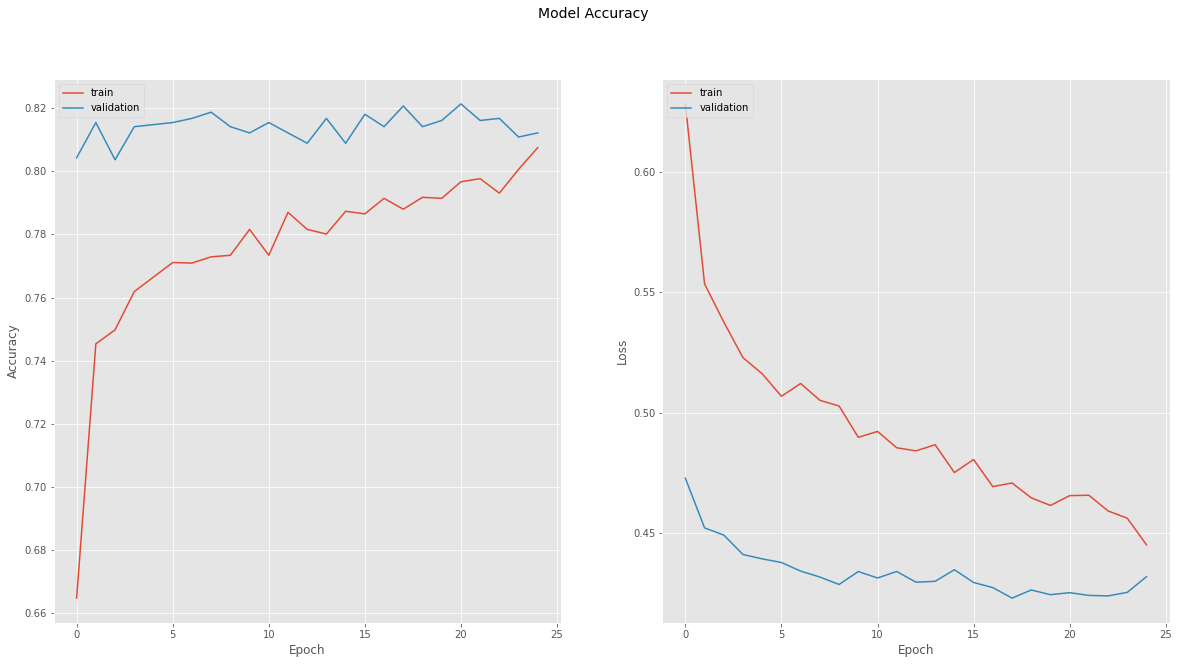

In [25]:
plot_learning_curves(dual_history)

In [27]:
#create submission for complex lstm model
submission_lstm2 = pd.DataFrame()
submission_lstm2['id'] = test_id
submission_lstm2['prob'] = dual_lstm.predict([nlp_test, meta_test])
submission_lstm2['target'] = submission_lstm2['prob'].apply(lambda x: 0 if x < .5 else 1)
submission_lstm2[['id', 'target']].head(10)

,id,prob,target
0,0,0.671591,1
1,2,0.861718,1
2,3,0.984882,1
3,9,0.632159,1
4,11,0.994358,1
5,12,0.585486,1
6,21,0.103669,0
7,22,0.101877,0
8,27,0.052737,0
9,29,0.064272,0


In [30]:
submission_lstm[['id', 'target']].to_csv("submit_disaster_lstm.csv", index=False)
submission_lstm2[['id', 'target']].to_csv("submit_disaster_lstm_dual.csv",index=False)

NameError: name 'submission_lstm' is not defined

In [29]:
submission_lstm2[['id', 'target']].head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
